<a href="https://colab.research.google.com/github/camlab-bioml/2021_IMC_Jett/blob/main/DAMM_adam_07262021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.optim as optim
import torch.distributions as D

import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

def retFig(Q, ll):
  fig, axs = plt.subplots(2)
  axs[0].set_ylabel('Q')
  axs[1].set_ylabel('ll')
  #fig.suptitle('trial 2 cluster=3', fontsize=16)

  ## Q
  axs[0].plot(Q, 'r')
  ## L
  axs[1].plot(ll, 'b')
  return fig
  
def _ics(logL, n_obs, n_features, n_clusters): #, n, p, c
  params = n_clusters * (n_features**2 + n_features + 4) + (n_clusters * n_clusters - n_clusters)/2
  return 2 * (params - logL), -2 * logL + params * np.log(n_obs)
  
def generateData(n_clusters = 3, n_obs = 10000, n_features = 2):

  ## set ground true expressions ##

  true_expression_means = torch.tensor([
      [3, 5],
      [6, 7],
      [9, 11]
  ])
  
  #true_expression_means = torch.randint(1, 11, (n_clusters, n_features))
  #print(true_expression_means)

  true_expression_covs = torch.tensor([
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]],
      [[.1, 0], [0, .1]]
  ])

  true_size_means = torch.tensor([.1, .5, .7])
  #true_size_means = torch.rand(n_clusters)
  #print(true_size_means)

  true_size_stds = torch.tensor([.01, .01, .01])
  #true_size_stds

  ## other ground true for generating data ##
  d_ws = torch.tensor([.95, .05])
  
  #z_ws = torch.tensor([1 / 4, 1 / 2, 1 / 4])
  z_ws = np.random.rand(n_clusters)
  z_ws /= z_ws.sum()
  #print(z_ws.sum())

  #g_ws = torch.tensor([0.0667, 0.1333, 0.2000, 0.1000, 0.2667, 0.2333])
  n_events = int((n_clusters * n_clusters - n_clusters)/2 + n_clusters)
  g_ws = np.random.rand(n_events)
  g_ws /= g_ws.sum()
  #print(g_ws.sum())
  
  gs = np.sum(np.random.choice(2, size = n_obs, p = d_ws))
  zs = n_obs - gs

  ## simulate data
  x = np.zeros((zs, n_features+4))
  for i in range(zs):
    z = np.random.choice(n_clusters, size = 1, p = z_ws)[0]
    x[i] = np.append(np.random.multivariate_normal(true_expression_means[z], true_expression_covs[z]), [np.random.normal(true_size_means[z], true_size_stds[z]), 0, z, z+6])
  
  xxx = np.zeros((gs, n_features+4))
  for i in range(gs):

    g = np.random.choice(6, size = 1, p = g_ws)[0]
    
    if g == 0:
      idx = [0,0]
    elif g == 1:
      idx = [0,1]
    elif g == 2:
      idx = [0,2]
    elif g == 3:
      idx = [1,1]
    elif g == 4:
      idx = [1,2]
    else:
      idx = [2,2]
  
    xxx[i] = np.append(np.random.multivariate_normal( (true_expression_means[idx[0]] + true_expression_means[idx[1]]), (true_expression_covs[idx[0]] + true_expression_covs[idx[1]]) ),
                     [np.random.normal( (true_size_means[idx[0]] + true_size_means[idx[1]]), (true_size_stds[idx[0]] + true_size_stds[idx[1]]) ), 1, g, g])
  
  xx = np.append(x, xxx).reshape(n_obs,6)

  ## check number of points in each cluster
  for i in range(9):
    print(sum(xx[:,5] == i)/n_obs)
  
  print(gs)

  return torch.tensor(xx[:,:2]), torch.tensor(xx[:,2])

## initialization
def initialization(n_clusters, X, S):

  n_obs, n_features = X.shape

  #torch.manual_seed(seed_num)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
  #pi_d0 = torch.tensor(0.9)
  pi_d0 = torch.tensor(np.random.uniform(.9, 1))
  
  pi_c = torch.empty(n_clusters).fill_(1. / (n_clusters))
  
  pi_cc = torch.triu(torch.ones(n_clusters, n_clusters))
  pi_cc = pi_cc / torch.sum(pi_cc)
  pi_cc[pi_cc == 0] = float('NaN')

  emu_c = X[np.random.choice(n_obs, n_clusters, replace=False)].float()

  '''
  emu_c = torch.tensor([
    [2, 6], # 1 2
    [5, 8], # 4 3
    [9, 10] #7 9
  ], dtype=torch.float) #, requires_grad=True, , device=device)
  '''

  smu_c = S[np.random.choice(n_obs, n_clusters, replace=False)].float()
  #smu_c = torch.tensor([.3, .5, .7], dtype=torch.float) #, requires_grad=True,  device=device)

  eco_c = 0.1 * torch.eye(n_features).tile(n_clusters, 1, 1)
  #eco_c = 0.1 * torch.ones(n_clusters, n_features, dtype=torch.float)
  sco_c = 0.01 * torch.ones(n_clusters, dtype=torch.float)

  smu_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)
  sco_cc = torch.zeros(n_clusters, n_clusters, dtype=torch.float)

  emu_cc = torch.zeros(n_clusters, n_clusters, n_features, dtype=torch.float)
  eco_cc = torch.zeros(n_clusters, n_clusters, n_features, n_features, dtype=torch.float)

  for j in range(n_clusters):
    for k in range(n_clusters):
      if k >= j:
        smu_cc[j,k] = smu_c[j] + smu_c[k]
        sco_cc[j,k] = sco_c[j] + sco_c[k]

        emu_cc[j,k] = (emu_c[j] + emu_c[k])
        eco_cc[j,k] = (eco_c[j] + eco_c[k])

  params1 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  smu_c = torch.tensor(smu_c, requires_grad=True, dtype=torch.float, device=device)
  sco_c = torch.tensor(sco_c, requires_grad=True, dtype=torch.float, device=device)
      
  emu_c = torch.tensor(emu_c, requires_grad=True, dtype=torch.float, device=device)
  eco_c = torch.tensor(eco_c, requires_grad=True, dtype=torch.float, device=device)
      
  smu_cc = torch.tensor(smu_cc, requires_grad=True, dtype=torch.float, device=device)
  sco_cc = torch.tensor(sco_cc, requires_grad=True, dtype=torch.float, device=device)
      
  emu_cc = torch.tensor(emu_cc, requires_grad=True, dtype=torch.float, device=device)
  eco_cc = torch.tensor(eco_cc, requires_grad=True, dtype=torch.float, device=device)

  hyperparams = [pi_d0, pi_c, pi_cc]
  params2 = [emu_c, eco_c, smu_c, sco_c, emu_cc, eco_cc, smu_cc, sco_cc]

  return hyperparams, params1, params2

def _estimate_covariances_diag(X, n_c, resp, means, reg_covar=1e-6):
  
  avg_X2 = torch.mm(resp.T, X * X).T / n_c # pxc
  avg_means2 = means ** 2 # cxp
  avg_X_means = (means * torch.mm(resp.T, X)).T / n_c # pxc
  return avg_X2.T - 2 * avg_X_means.T + avg_means2 + reg_covar

def initial(n_clusters, X, S):

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  n_obs, n_features = X.shape
  
  num_components = int((n_clusters * n_clusters - n_clusters)/2 + 2*n_clusters)
  #kms = KMeans(num_components).fit(S.reshape(-1,1))
  
  gmm = GaussianMixture(num_components).fit(S.reshape(-1,1))
  preds = pd.DataFrame(gmm.predict(S.reshape(-1,1)))
  topkcounts = preds.value_counts().sort_values(ascending=False)
  #print(topkcounts)

  smu = torch.zeros(n_clusters, dtype=torch.float)
  sco = torch.zeros(n_clusters, dtype=torch.float)

  emu = torch.zeros(n_clusters, n_features, dtype=torch.float, )
  ecof = torch.zeros(n_clusters, n_features, n_features, dtype=torch.float)
  ecod = torch.zeros(n_clusters, n_features, dtype=torch.float)

  for j in range(n_clusters):
    svals = (np.array(S)[(preds == topkcounts.index.tolist()[j]).squeeze()])
    smu[j] = torch.tensor(svals.mean())
    sco[j] = torch.tensor(svals.std())

    evals = (np.array(X)[(preds == topkcounts.index.tolist()[j]).squeeze()])
    emu[j] = torch.tensor(evals.mean(0))

    ecof[j] = torch.tensor(np.cov(evals.T)) # full
    ecod[j] = torch.tensor(evals.std(0)) ## diag

  lambda_d0 = torch.tensor(topkcounts[:n_clusters].sum() / n_obs)
  pi_c = torch.tensor((topkcounts[:n_clusters] / n_obs).values)

  tau_cc = torch.triu(torch.ones(n_clusters, n_clusters, dtype=torch.float64))
  tau_cc[tau_cc == 0] = float('NaN')
  
  for j in range(n_clusters):
    for k in range(n_clusters):
      if not torch.isnan(tau_cc[j,k]):
        _, idx = abs((smu[j] + smu[k]) - gmm.means_).min(0)
        tau_cc[j,k] = (preds == idx).squeeze().sum() / n_obs

  hps = [lambda_d0, pi_c, tau_cc]
  ngps = [smu, sco, emu, ecof, ecod]

  smu = torch.tensor(smu, requires_grad=True, dtype=torch.float, device=device)
  sco = torch.tensor(sco, requires_grad=True, dtype=torch.float, device=device)

  emu = torch.tensor(emu, requires_grad=True, dtype=torch.float, device=device)
  ecof = torch.tensor(ecof, requires_grad=True, dtype=torch.float, device=device)
  ecod = torch.tensor(ecod, requires_grad=True, dtype=torch.float, device=device)

  return hps, ngps, [smu, sco, emu, ecof], [smu, sco, emu, ecod]

In [2]:
## torch.optim version (function)
def em_v2(X, S, hyperparameters, parameters, n_epochs = 1000, tot = 1e-4):

  init_hps = hyperparameters
  init_params = parameters

  n_obs, n_features = X.shape
  n_clusters = len(hyperparameters[1])

  pi_d0 = hyperparameters[0]
  pi_d1 = 1-hyperparameters[0]
  pi_c = hyperparameters[1]
  pi_cc = hyperparameters[2]

  #opt = optim.SGD(parameters, lr=0.01)
  opt = optim.Adam(parameters)

  iter = 0
  qs = [0]
  ls = [float('-inf')]

  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)
  
    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)
  
    for j in range(n_clusters):

      sl0 = D.Normal(parameters[0][j], parameters[1][j]).log_prob(S.float())
      el0 = D.MultivariateNormal(parameters[2][j], parameters[3][j]).log_prob(X.float())

      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:

          sl1 = D.Normal((parameters[0][j] + parameters[0][k]), parameters[1][j] + parameters[1][k]).log_prob(S.float())
          el1 = D.MultivariateNormal((parameters[2][j] + parameters[2][k]), (parameters[3][j] + parameters[3][k])).log_prob(X.float())

          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    L = log_rdzg_norm.mean()
    loss = -L
        
    opt.zero_grad()
    loss.backward()
    opt.step()

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot or pi_d0 < tot:
      print("d is approaching 0! -> change a different initalization values")
      break

    with torch.no_grad():
      
      parameters[0].clamp_(tot)
      parameters[1].clamp_(tot)
      parameters[2].clamp_(tot)
      ##parameters[3].clamp_(tot)
      
      parameters[3] += torch.eye(n_features) * 0.01
      
      log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
      log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

      assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

      l1 = log_rd0z_top.T + log_rdz
      l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
      L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

      q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0
      q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0
      Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean()

      qs.append(Q)
      ls.append(L)
      iter += 1

      rdz = torch.exp(log_rdz)    
      n_c = torch.sum(rdz, dim=0) #+ tot
      pi_c = n_c / n_obs
      pi_d0 = torch.sum(pi_c)

      rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
      n_cc = torch.sum(rdg, dim=0)
      pi_cc = n_cc / n_obs
      pi_d1 = torch.sum(torch.triu(pi_cc))

  aic, bic = _ics(L, n_obs, n_features, n_clusters)

  print('# of clusters', n_clusters, 'Converged in Iteration', iter + 1, 'Likelihood: ', L, 'Likelihood1: ', L1, 'd0: ', pi_d0, 'BIC: ', bic, aic)
  return n_clusters, ls[1:], qs[1:], aic, bic, pi_d0, n_c, pi_c, pi_d1, n_cc, pi_cc, parameters, init_hps, init_params

#[3, 5],
#[6, 7],
#[9, 11]

In [3]:
'''
#could add LowRankMultivariateNormal
k = 1
n_clusters = 3
n_features = 2
cov_facts = torch.rand(n_clusters, n_features, k, requires_grad=True, dtype=torch.float)
cov_diags = torch.tensor([
    [.1, .1],
    [.1, .1],
    [.1, .1]
], requires_grad=True, dtype=torch.float)
el0 = D.LowRankMultivariateNormal(emu_c[j], cov_facts[j], cov_diags[j]).log_prob(X.float())
'''
#cov_facts = torch.zeros(n_clusters, n_features, 1, requires_grad=True, dtype=torch.float)
#D.LowRankMultivariateNormal(inits[2][0][j], cov_facts[j], cov_diags[j]).log_prob(X.float())
#cov_facts[j] @ cov_facts[j].T + torch.eye(n_features) * cov_diags[j]

## torch.optim version (function)
def em_v3(X, S, hyperparameters, parameters, n_epochs = 1000, tot = 1e-4):

  init_hps = hyperparameters
  init_params = parameters

  n_obs, n_features = X.shape
  n_clusters = len(hyperparameters[1])

  pi_d0 = hyperparameters[0]
  pi_d1 = 1-hyperparameters[0]
  pi_c = hyperparameters[1]
  pi_cc = hyperparameters[2]

  #opt = optim.SGD(parameters, lr=0.01)
  opt = optim.Adam(parameters)

  cov_facts = torch.zeros(n_clusters, n_features, 1, requires_grad=False, dtype=torch.float)

  iter = 0
  qs = [0]
  ls = [float('-inf')]

  while iter < n_epochs:

    log_lambda0_pi = torch.log(pi_d0) + torch.log(pi_c)
    log_lambda1_tau = torch.log(1 - pi_d0) + torch.log(pi_cc)
  
    ### E-step:
    log_rd0z_top = torch.zeros(n_clusters, n_obs)
    log_rd1g_top = torch.zeros(n_clusters, n_clusters, n_obs)
  
    for j in range(n_clusters):

      sl0 = D.Normal(parameters[0][j], parameters[1][j]).log_prob(S.float())
      el0 = D.LowRankMultivariateNormal(parameters[2][j], cov_facts[j], parameters[3][j]).log_prob(X.float())

      log_rd0z_top[j] = log_lambda0_pi[j] + el0 + sl0
    
      for k in range(n_clusters):
        if torch.isnan(log_lambda1_tau[j,k]): #lower triangular nan
          log_rd1g_top[j,k] = float("NaN")
        else:
          sl1 = D.Normal((parameters[0][j] + parameters[0][k]), parameters[1][j] + parameters[1][k]).log_prob(S.float())
          el1 = D.LowRankMultivariateNormal((parameters[2][j] + parameters[2][k]), cov_facts[j] + cov_facts[k], (parameters[3][j] + parameters[3][k])).log_prob(X.float())

          log_rd1g_top[j,k] = log_lambda1_tau[j,k] + el1 + sl1

    log_rd1g_top = log_rd1g_top.reshape(n_clusters * n_clusters, n_obs) #shape: (cxc')xn

    ignored_indices = torch.isnan(torch.logsumexp(log_rd1g_top, 1))
    assert(ignored_indices.sum() == (n_clusters * n_clusters - n_clusters) / 2)
    
    log_rdzg_norm = torch.logsumexp(torch.vstack((log_rd0z_top, log_rd1g_top[~ignored_indices])),0) #shape: n
    #log_rdzg_norm1 = torch.logsumexp(torch.vstack((torch.logsumexp(log_rd0z_top, 0), torch.logsumexp(log_rd1g_top[~ignored_indices],0))),0)

    L = log_rdzg_norm.mean()
    loss = -L
        
    opt.zero_grad()
    loss.backward()
    opt.step()

    if abs(ls[-1] - L) < tot:
      break

    if pi_d1 < tot or pi_d0 < tot:
      print("d is approaching 0! -> change a different initalization values")
      break

    with torch.no_grad():
      
      parameters[0].clamp_(tot)
      parameters[1].clamp_(tot)
      parameters[2].clamp_(tot)
      parameters[3].clamp_(tot)

      log_rdz = (log_rd0z_top - log_rdzg_norm).T #shape: nxc
      log_rdg = (log_rd1g_top - log_rdzg_norm).T #shape: nx(cxc')

      assert(torch.sum(torch.sum(torch.exp(log_rdz),1) + torch.sum(torch.exp(log_rdg[:,~ignored_indices]),1)).round() == n_obs)

      l1 = log_rd0z_top.T + log_rdz
      l2 = log_rd1g_top[~ignored_indices].T + log_rdg[:,~ignored_indices]; #l2[torch.isinf(l2)] = -100
      L1 = torch.vstack((torch.logsumexp(l1,1), torch.logsumexp(l2,1))).logsumexp(0).mean()

      q1 = log_rd0z_top.T * log_rdz.exp(); q1[torch.isnan(q1)] = 0.0
      q2 = log_rd1g_top[~ignored_indices].T * log_rdg[:,~ignored_indices].exp(); q2[torch.isnan(q2)] = 0.0
      Q = torch.vstack((torch.logsumexp(q1, 1), torch.logsumexp(q2, 1))).logsumexp(0).mean()

      qs.append(Q)
      ls.append(L)
      iter += 1

      rdz = torch.exp(log_rdz)    
      n_c = torch.sum(rdz, dim=0) #+ tot
      pi_c = n_c / n_obs
      pi_d0 = torch.sum(pi_c)

      rdg = torch.exp(log_rdg).reshape(n_obs, n_clusters, n_clusters)
      n_cc = torch.sum(rdg, dim=0)
      pi_cc = n_cc / n_obs
      pi_d1 = torch.sum(torch.triu(pi_cc))

  aic, bic = _ics(L, n_obs, n_features, n_clusters)

  print('# of clusters', n_clusters, 'Converged in Iteration', iter + 1, 'Likelihood: ', L, 'Likelihood1: ', L1, 'd0: ', pi_d0, 'BIC: ', bic, aic)
  return n_clusters, ls[1:], qs[1:], aic, bic, pi_d0, n_c, pi_c, pi_d1, n_cc, pi_cc, parameters, init_hps, init_params

#[3, 5],
#[6, 7],
#[9, 11]

In [4]:
#X, S = generateData(3, 10000, 2)
#inits = initial(3, X, S)
#fit1 = em_v2(X, S, inits[0], inits[2], 1000)
#fit2 = em_v3(X, S, inits[0], inits[3], 1000)

0.009
0.003
0.0122
0.0065
0.012
0.0073
0.2108
0.3577
0.3815
500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 1 Converged in Iteration 1001 Likelihood:  tensor(-5.1503, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-5.1536) d0:  tensor(0.9641) BIC:  tensor(102.4040, grad_fn=<AddBackward0>) tensor(30.3006, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 2 Converged in Iteration 1001 Likelihood:  tensor(-3.2284, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-3.2293) d0:  tensor(0.9590) BIC:  tensor(199.8740, grad_fn=<AddBackward0>) tensor(48.4568, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 3 Converged in Iteration 230 Likelihood:  tensor(1.0844, grad_fn=<MeanBackward0>) Likelihood1:  tensor(1.0843) d0:  tensor(0.9500) BIC:  tensor(301.7725, grad_fn=<AddBackward0>) tensor(63.8312, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 4 Converged in Iteration 224 Likelihood:  tensor(1.0842, grad_fn=<MeanBackward0>) Likelihood1:  tensor(1.0836) d0:  tensor(0.9500) BIC:  tensor(421.5072, grad_fn=<AddBackward0>) tensor(89.8316, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 5 Converged in Iteration 218 Likelihood:  tensor(1.0841, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.9385) d0:  tensor(0.9500) BIC:  tensor(550.4523, grad_fn=<AddBackward0>) tensor(117.8319, grad_fn=<MulBackward0>)
0.003
0.0049
0.0061
0.0131
0.0113
0.0136
0.0668
0.4447
0.4365
520


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 1 Converged in Iteration 1001 Likelihood:  tensor(-4.3950, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-4.3959) d0:  tensor(0.9564) BIC:  tensor(100.8934, grad_fn=<AddBackward0>) tensor(28.7901, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 2 Converged in Iteration 1001 Likelihood:  tensor(-1.3274, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-1.3274) d0:  tensor(0.9511) BIC:  tensor(196.0719, grad_fn=<AddBackward0>) tensor(44.6548, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 3 Converged in Iteration 231 Likelihood:  tensor(1.2097, grad_fn=<MeanBackward0>) Likelihood1:  tensor(1.2096) d0:  tensor(0.9481) BIC:  tensor(301.5218, grad_fn=<AddBackward0>) tensor(63.5805, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 4 Converged in Iteration 1001 Likelihood:  tensor(0.1390, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.1389) d0:  tensor(0.9559) BIC:  tensor(423.3976, grad_fn=<AddBackward0>) tensor(91.7220, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 5 Converged in Iteration 1001 Likelihood:  tensor(-0.8580, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-0.8607) d0:  tensor(0.9558) BIC:  tensor(554.3365, grad_fn=<AddBackward0>) tensor(121.7161, grad_fn=<MulBackward0>)
0.0057
0.0129
0.0081
0.0019
0.0112
0.0087
0.4084
0.249
0.2941
485


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 1 Converged in Iteration 1001 Likelihood:  tensor(-6.0312, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-6.0333) d0:  tensor(0.9715) BIC:  tensor(104.1658, grad_fn=<AddBackward0>) tensor(32.0624, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 2 Converged in Iteration 1001 Likelihood:  tensor(-2.2354, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-2.2356) d0:  tensor(0.7151) BIC:  tensor(197.8879, grad_fn=<AddBackward0>) tensor(46.4708, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 3 Converged in Iteration 486 Likelihood:  tensor(1.0814, grad_fn=<MeanBackward0>) Likelihood1:  tensor(1.0813) d0:  tensor(0.9515) BIC:  tensor(301.7784, grad_fn=<AddBackward0>) tensor(63.8372, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 4 Converged in Iteration 17 Likelihood:  tensor(0.6270, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.3335) d0:  tensor(0.9516) BIC:  tensor(422.4218, grad_fn=<AddBackward0>) tensor(90.7461, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 5 Converged in Iteration 215 Likelihood:  tensor(1.0814, grad_fn=<MeanBackward0>) Likelihood1:  tensor(1.0812) d0:  tensor(0.9515) BIC:  tensor(550.4577, grad_fn=<AddBackward0>) tensor(117.8373, grad_fn=<MulBackward0>)
0.0082
0.0136
0.0047
0.0089
0.0147
0.0006
0.423
0.1481


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

0.3782
507
# of clusters 1 Converged in Iteration 1001 Likelihood:  tensor(-6.9162, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-6.9197) d0:  tensor(0.9809) BIC:  tensor(105.9358, grad_fn=<AddBackward0>) tensor(33.8324, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 2 Converged in Iteration 903 Likelihood:  tensor(-1.7062, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-1.7068) d0:  tensor(0.8144) BIC:  tensor(196.8296, grad_fn=<AddBackward0>) tensor(45.4125, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 3 Converged in Iteration 1001 Likelihood:  tensor(-1.1147, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-1.1148) d0:  tensor(0.8148) BIC:  tensor(306.1706, grad_fn=<AddBackward0>) tensor(68.2294, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 4 Converged in Iteration 1001 Likelihood:  tensor(0.2526, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.2506) d0:  tensor(0.8148) BIC:  tensor(423.1705, grad_fn=<AddBackward0>) tensor(91.4948, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 5 Converged in Iteration 1001 Likelihood:  tensor(0.2992, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.2991) d0:  tensor(0.8148) BIC:  tensor(552.0220, grad_fn=<AddBackward0>) tensor(119.4016, grad_fn=<MulBackward0>)
0.0058
0.0163
0.0005
0.0098
0.0114
0.005
0.8264
0.0859
0.0389
488


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

# of clusters 1 Converged in Iteration 1001 Likelihood:  tensor(-3.5781, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-3.5781) d0:  tensor(0.8264) BIC:  tensor(99.2595, grad_fn=<AddBackward0>) tensor(27.1561, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourc

# of clusters 2 Converged in Iteration 591 Likelihood:  tensor(0.8744, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.8743) d0:  tensor(0.9123) BIC:  tensor(191.6684, grad_fn=<AddBackward0>) tensor(40.2513, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourc

# of clusters 3 Converged in Iteration 230 Likelihood:  tensor(1.6592, grad_fn=<MeanBackward0>) Likelihood1:  tensor(1.6592) d0:  tensor(0.9512) BIC:  tensor(300.6227, grad_fn=<AddBackward0>) tensor(62.6815, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourc

# of clusters 4 Converged in Iteration 717 Likelihood:  tensor(0.9367, grad_fn=<MeanBackward0>) Likelihood1:  tensor(0.9259) d0:  tensor(0.9123) BIC:  tensor(421.8023, grad_fn=<AddBackward0>) tensor(90.1266, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:236: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:239: UserWarning: To copy construct from a tensor, it is recommended to use sourc

# of clusters 5 Converged in Iteration 1001 Likelihood:  tensor(-2.2324, grad_fn=<MeanBackward0>) Likelihood1:  tensor(-2.2355) d0:  tensor(0.8264) BIC:  tensor(557.0853, grad_fn=<AddBackward0>) tensor(124.4649, grad_fn=<MulBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


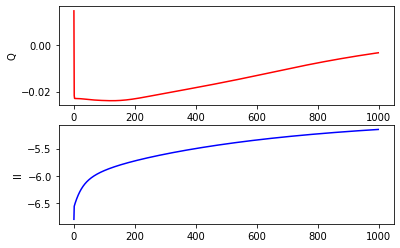

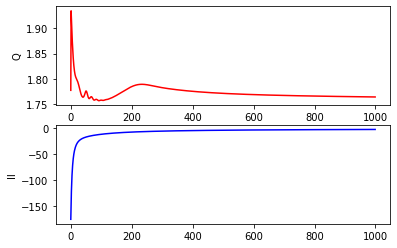

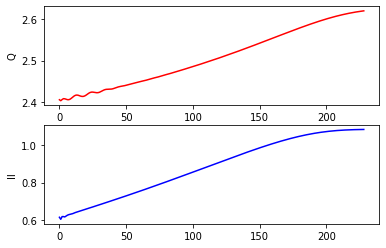

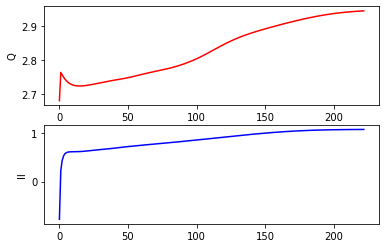

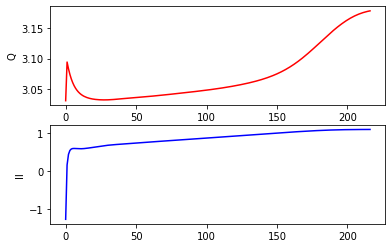

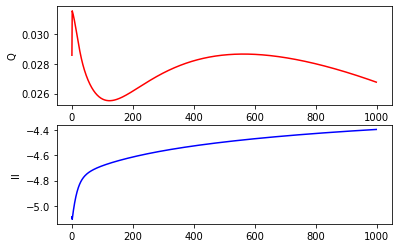

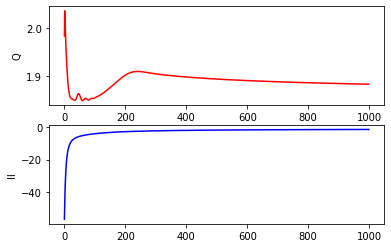

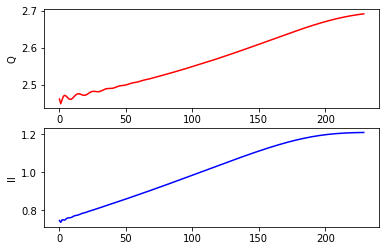

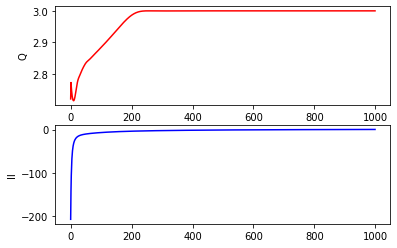

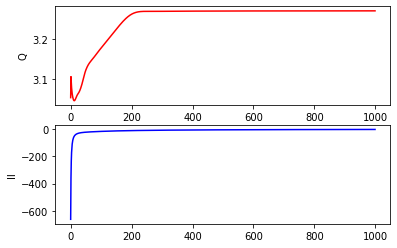

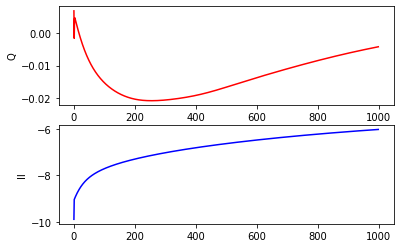

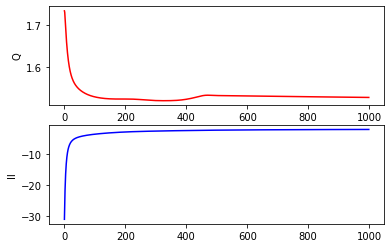

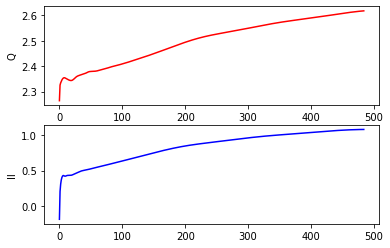

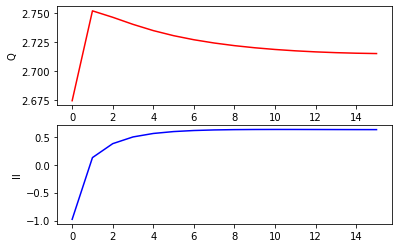

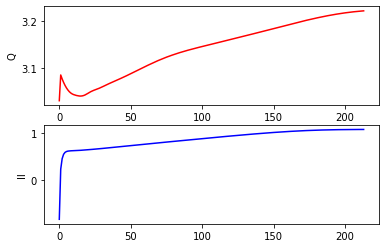

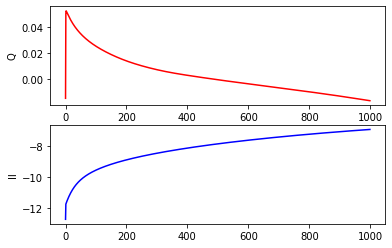

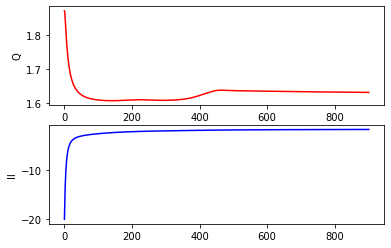

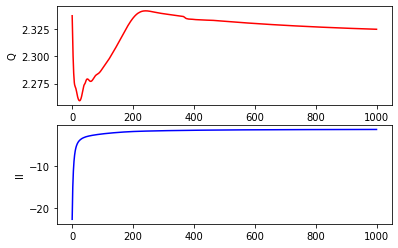

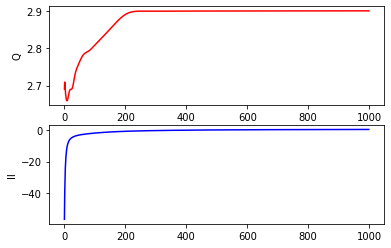

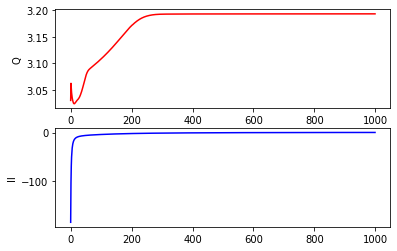

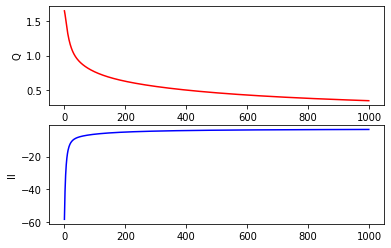

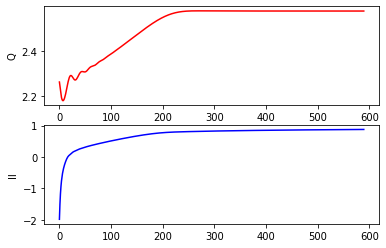

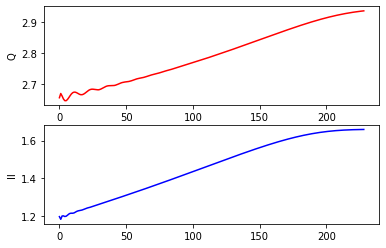

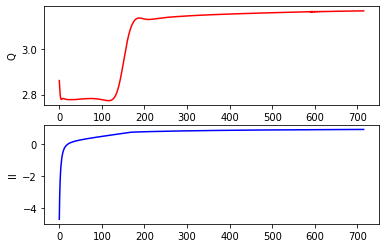

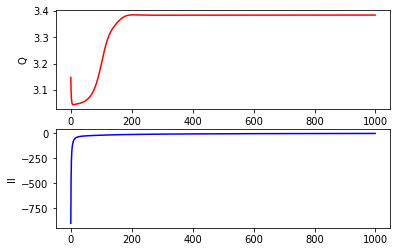

In [5]:
n_trials = 5
history = []
pp = PdfPages('p4.pdf')
for trial in range(n_trials):
  X, S = generateData(3, 10000, 2)
  for sn_clust in range(1, 6):
    inits = initial(sn_clust, X, S)
    #fit1 = em_v2(X, S, inits[0], inits[2], 1000) #full
    fit2 = em_v3(X, S, inits[0], inits[3], 1000) #diag
    history.append(fit2)
    pp.savefig(retFig(fit2[2], fit2[1])) ##Q, L
pp.close()